# Đây là NOTEBOOK thực nghiệm sử dụng Scheduler "Reduce Lr On Plateau" trong quá trình train, giúp cân nhắc việc sử dụng module này

Các quá trình thực nghiệm được thể hiện trong các notebook sau:
1.   [Model MobileNetV3, không scheduler, nhận learning rate = 5e-5](https://colab.research.google.com/drive/119gHyxtZN8JAfFSC8ZN5s_Fn0WGiwjqR?usp=sharing)
2.   [Model MobileNetV3, có scheduler "Reduce Lr On Plateau", learning rate = 5e-5](https://colab.research.google.com/drive/1DzKmkps8jJ2h4he-N4VXYBaF10su5Q1j?usp=drive_link)
3.   [Model MobileNetV3, không scheduler, learning rate = 1e-8](https://colab.research.google.com/drive/1jIOqals9RLu_IX0TTu7T0_2Gh4Q0_j6-?usp=drive_link)

* Mã nguồn trong 3 NOTEBOOK gần như giống nhau
* Sự khác biệt của các NOTEBOOK chỉ nằm trong 2 yếu tố Scheduler & Learning rate như trình bày trên

Đường dẫn đến NOTEBOOK giải nghĩa và so sánh:
<br>
 https://drive.google.com/file/d/1F1VaHuGNwdoEFH77yuHi-rHKkNMW-88W/view?usp=drive_link

## Import các thư viện cần thiết

In [ ]:
import os
import random
from datetime import datetime
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import json
import matplotlib.pyplot as plt
from torch.nn import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Biến toàn cục

In [ ]:
label_mapping = {
    'Others': 0,
    'Honda': 1,
    'Suzuki': 2,
    'Yamaha': 3,
    'VinFast': 4
}
reverse_label_mapping={
    0: 'Others',
    1: 'Honda',
    2: 'Suzuki',
    3: 'Yamaha',
    4: 'VinFast'
}

## Lớp CustomImageDataset kế thừa từ Dataset để có thể load ảnh theo định dạng của Dataframe chứa đường dẫn các ảnh có thể load được format RGB

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df, save_dir, transform=None):
        self.df = df
        self.save_dir = save_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # print(self.df.iloc[idx]['full_path'])
        img_path = os.path.join(self.save_dir , self.df.iloc[idx]['full_path'])
        label = self.df.iloc[idx]['label_idx']

        # Open the image file
        image = Image.open(img_path).convert('RGB')

        # Apply transformation if provided
        if self.transform:
            image = self.transform(image)

        return image, label

## Lọc ra những đường dẫn của Image có thể load được
## Lọc dataframe split 1 của Thầy Duy, thành 1 Dataframe nhỏ hơn (chứa các đường dẫn)
## Dataframe nhỏ hơn này có chứa 8000 ảnh có thể load được và được chia thành training set và validation set lần lượt theo tỉ lệ 8:2

In [ ]:
def can_load_image(file_path):
    try:
        image = Image.open(file_path).convert('RGB')
        return True
    except Exception as ex:  # Catch all exceptions (FileNotFoundError, IOError, etc.)
        # print(ex)
        return False

In [ ]:
df_path_split_1 = pd.read_csv("MotocycleDataset-train-clean-1.csv")
df_path_split_1

,full_path,label_idx
0,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1
1,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1
2,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1
3,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1
4,./CLASS-IMAGES/Honda/22520968-22520996-2252099...,1
...,...,...
27774,./CLASS-IMAGES/Others/22520033-22520035-225200...,0
27775,./CLASS-IMAGES/Others/22520033-22520035-225200...,0
27776,./CLASS-IMAGES/Others/22520033-22520035-225200...,0
27777,./CLASS-IMAGES/Others/22520033-22520035-225200...,0


In [ ]:
df_path_DEMO = df_path_split_1.sample(8000,ignore_index=True)
df_path_DEMO["full_path"] = df_path_DEMO["full_path"].apply(
    lambda x: x.replace("./CLASS-IMAGES", "./drive/MyDrive/my_shared_shortcut/Public")
)
df_path_DEMO

,full_path,label_idx
0,./drive/MyDrive/my_shared_shortcut/Public/Yama...,3
1,./drive/MyDrive/my_shared_shortcut/Public/Yama...,3
2,./drive/MyDrive/my_shared_shortcut/Public/Hond...,1
3,./drive/MyDrive/my_shared_shortcut/Public/Hond...,1
4,./drive/MyDrive/my_shared_shortcut/Public/VinF...,4
...,...,...
7995,./drive/MyDrive/my_shared_shortcut/Public/Othe...,0
7996,./drive/MyDrive/my_shared_shortcut/Public/Yama...,3
7997,./drive/MyDrive/my_shared_shortcut/Public/Yama...,3
7998,./drive/MyDrive/my_shared_shortcut/Public/VinF...,4


In [ ]:
df_path_DEMO.to_csv("DEMO-LEARNING-RATE-UPDATE.csv", index=False)

In [ ]:
train_df, val_df = train_test_split(df_path_DEMO, test_size=0.2, random_state=42)

In [ ]:
train_df.reset_index(drop=True,inplace=True)
train_df.to_csv("DEMO-LEARNING-RATE-train.csv", index=False)
train_df.head()

,full_path,label_idx
0,./drive/MyDrive/my_shared_shortcut/Public/Suzu...,2
1,./drive/MyDrive/my_shared_shortcut/Public/VinF...,4
2,./drive/MyDrive/my_shared_shortcut/Public/Othe...,0
3,./drive/MyDrive/my_shared_shortcut/Public/Yama...,3
4,./drive/MyDrive/my_shared_shortcut/Public/Othe...,0


In [ ]:
val_df.reset_index(drop=True,inplace=True)
val_df.to_csv("DEMO-LEARNING-RATE-val.csv", index=False)
val_df.head()

,full_path,label_idx
0,./drive/MyDrive/my_shared_shortcut/Public/Othe...,0
1,./drive/MyDrive/my_shared_shortcut/Public/Suzu...,2
2,./drive/MyDrive/my_shared_shortcut/Public/Hond...,1
3,./drive/MyDrive/my_shared_shortcut/Public/Hond...,1
4,./drive/MyDrive/my_shared_shortcut/Public/Suzu...,2


## Unzip các resource đã chuẩn bị từ trước (bao gồm các ảnh trong dataset của lớp)
## Đọc training set, validation set đã chuẩn bị sẵn từ trước đó

In [ ]:
!ls "./drive/MyDrive/my_shared_shortcut"

CLASS-IMAGES.zip  inout.zip  MODELS-logs  Public  raw.zip


In [ ]:
!unzip "./drive/MyDrive/my_shared_shortcut/CLASS-IMAGES.zip" -d ./

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.19.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.2.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.20.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.21.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.22.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.23.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.24.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.25.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.26.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.27.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.28.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.29.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-21522821.Yamaha.3.jpg  
  inflating: ./CLASS-IMAGES/Yamaha/21522734-2152

## Đọc lại Dataframe từ csv: danh sách đường dẫn các ảnh dùng để train và validate

In [ ]:
train_df = pd.read_csv("./drive/MyDrive/my_shared_shortcut/MODELS-logs/DEMO-LEARNING-RATE-train.csv")
val_df = pd.read_csv("./drive/MyDrive/my_shared_shortcut/MODELS-logs/DEMO-LEARNING-RATE-val.csv")

In [ ]:
train_df

,full_path,label_idx
0,./CLASS-IMAGES/Suzuki/21522664-21522602.Suzuki...,2
1,./CLASS-IMAGES/Yamaha/22521705-22520777-225202...,3
2,./CLASS-IMAGES/Suzuki/22520896-22520926-225216...,2
3,./CLASS-IMAGES/Honda/22521293-22520105-2252162...,1
4,./CLASS-IMAGES/Suzuki/22521402.Suzuki.22.jpg,2
...,...,...
6395,./CLASS-IMAGES/VinFast/22520368.VinFast.45.jpg,4
6396,./CLASS-IMAGES/VinFast/22520327.VinFast.28.jpg,4
6397,./CLASS-IMAGES/Yamaha/22521293-22520105-225216...,3
6398,./CLASS-IMAGES/Others/22520968-22520996-225209...,0


## Visualize một vài ảnh từ Dataloader (torch.utils.data.DataLoader)

In [ ]:
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
dataset = CustomImageDataset(train_df, save_dir="./", transform=transform)

In [ ]:
def show_images(images, labels, n_images=10, mapping={}):
    images = images.permute(0, 2, 3, 1).numpy()
    fig, axes = plt.subplots(1, n_images, figsize=(15, 15))
    for i in range(n_images):
        image = images[i]
        label = mapping[labels[i].item()]
        # Show the image
        ax = axes[i]
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(label)

    plt.show()

In [ ]:
data_loader_display = DataLoader(dataset, batch_size=32, shuffle=True)
data_iter_transformed = iter(data_loader_display)
images, labels = next(data_iter_transformed)

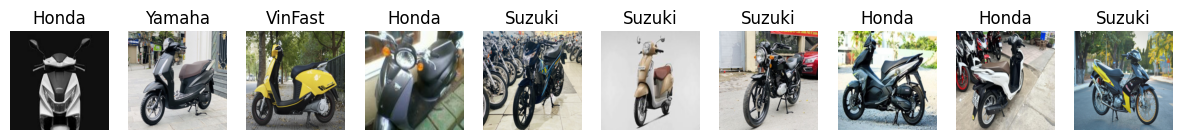

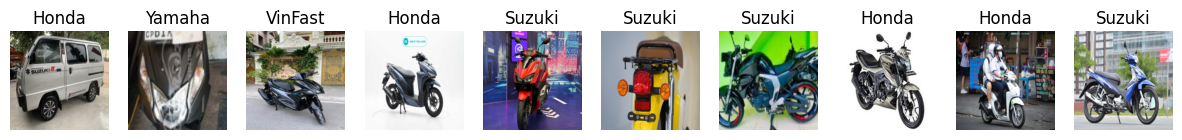

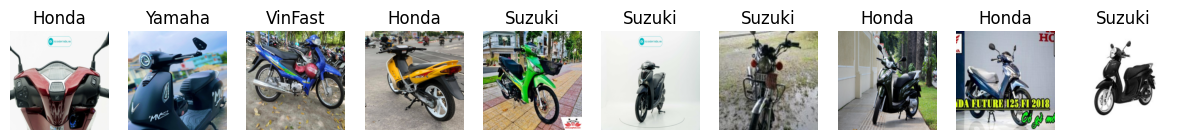

In [ ]:
show_images(images[:10], labels, n_images=10,mapping=reverse_label_mapping)
show_images(images[10:20], labels, n_images=10,mapping=reverse_label_mapping)
show_images(images[20:], labels, n_images=10, mapping=reverse_label_mapping)

## Chuẩn bị quá trình train

### 1. Chuẩn bị EarlyStopping để giới hạn resource GPU (thời gian train, số iteration train) sử dụng từ google Colab

In [ ]:
class EarlyStopping:
    def __init__(self, patience=15, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        # self.val_loss=1000

    def consume_loss(self, val_loss, model):
        print(f'in early: val_loss vs best_loss: {val_loss} - {self.best_loss}')
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')



### Chuẩn bị các hàm cần thiết để train Model
### Ở đây NOTEBOOK này sử dụng Scheduler để update Learning rate dựa trên min validation loss

Giải nghĩa hàm **"save_model"**: lưu lại các thước đo trong quá trình train làm **"check point"**. Các thước đo sẽ được sử dụng sau này để visualize và so sánh trong [NOTEBOOK so sánh](https://drive.google.com/file/d/1F1VaHuGNwdoEFH77yuHi-rHKkNMW-88W/view?usp=drive_link):
* learning rate: để theo dõi xem learning rate có bị update over epoch không
* epoch: thông tin lần train hiện tại là bao nhiêu
* train loss: giá trị của hàm Cross Entropy Loss tính được trong quá trình train
* validation loss: giá trị của hàm Cross Entropy Loss tính được trong quá trình validate
* checkpoint_savedir: địa điểm lưu lại các thước đo
<br>

Giải nghĩa hàm **"train_model"**: hàm chạy quá trình train theo framework của [PyTorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html):
* model: model được chọn trong quá trình train
* train_loader: [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) của training set
* val_loader: [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) của validation set
* criterion: module để tính loss [Cross Entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
* optimizer: module dùng để tối ưu trong quá trình chạy.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Vd: zero_grad() dùng để reset gradient sau khi thực hiện propagation và backpropagation sau mỗi batch
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Vd: optimizer.step() cập nhật weights sau khi đã thực hiện backpropagation
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.....
<br>
* scheduler: module giúp update Learning rate khi validation loss dao động quá nhiều sau một khoảng epoch train (number of training epochs)
* early_stopping: dừng sớm khi validation loss không cải thiện sau nhiều epochs


In [ ]:
def save_model(learning_rate, epoch, train_loss, val_loss, train_acc, val_acc, checkpoint_savedir):
    save_dict = {
        "lr": learning_rate,
        "val_loss": val_loss,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    }
    checkpoint_path = os.path.join(checkpoint_savedir, f'epoch_{epoch}.pth')
    torch.save(save_dict, checkpoint_path)
    print(f"saved metrics at epoch {epoch}: {checkpoint_path}")

def train_model(model, train_loader: DataLoader, val_loader: DataLoader,
                criterion, optimizer, scheduler, current_epoch, num_epochs, checkpoint_savedir='./models', early_stopping=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device: {device}")
    model.to(device)

    best_loss = float('inf')
    train_size = len(train_loader.dataset)
    val_size = len(val_loader.dataset)
    print(f"train size: {train_size}")
    print(f"val size: {val_size}")

    if not os.path.exists(checkpoint_savedir):
      os.makedirs(checkpoint_savedir)

    for epoch in range(current_epoch, num_epochs + 1):
        model.train()
        running_loss = 0.0

        # Training Phase
        train_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        train_acc = train_corrects * 100 / train_size
        print(f"Training Loss: {epoch_loss:.12f} ; Acc: {train_acc:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / val_size
        val_acc = val_corrects * 100 / val_size
        print(f"Validation Loss: {val_epoch_loss:.4f}; Acc: {val_acc:.4f}")

        # Log Learning Rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate: {current_lr:.12f}")

        # Update scheduler
        scheduler.step(val_epoch_loss)

        # Save checkpoint
        os.makedirs(checkpoint_savedir, exist_ok=True)
        save_model(current_lr, epoch, epoch_loss, val_epoch_loss, train_acc, val_acc, checkpoint_savedir)

        if early_stopping:
            early_stopping.consume_loss(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping!!!!!!!!!!!!!!!!!!")
                break

        # Save the best model based on validation loss
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss
            best_model_path = os.path.join(checkpoint_savedir, 'best_model.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model updated with validation loss {best_loss:.4f} and saved at {best_model_path}")


### Các transform để tăng cường hóa training Dataset trong quá trình train

In [ ]:
IMG_SIZE = 360
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE-24),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


### Định nghĩa model, cùng với các hyper-parameter có thể dùng để tinh chỉnh quá trình train
* In ra model của MobileNetV3, sau đó copy layer cuối cùng và chỉnh sửa out_features = 5 (đại diện cho 5 label)
* Device: chọn device để train
* criterion: module tính loss (ở đây sử dụng Cross Entropy Loss)
* optimizer: module giúp thực hiện quá trình train, cụ thể là thực hiện propagation và backpropagation, cũng như cập nhật weights, reset gradient sau mỗi batch
* scheduler: ở đây sử dụng ["Reduce Lr On Plateau"](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html). Module này giúp cập nhật learning rate dựa trên điều kiện đặt ra:
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;VD: ở đây chọn mode = min, patience = 5, factor = 0.1. Chọn cập nhật Learning rate dựa trên validation loss "scheduler.step(val_epoch_loss)", được thực hiên bên trong hàm train_model
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Module sẽ ghi nhận lại validation loss thấp nhất hiện tại sau mỗi epoch.
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Trong các lần, kế tiếp, nếu Module không cập nhật giá trị mới (do không thỏa điều kiện bé hơn validation loss đã ghi nhận trước đó). Module sẽ bắt đầu tính kiên nhẫn sau 5 lần. Và sẽ giảm learning_rate theo factor (0.1):
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; learning_rate = learning_rate x factor(0.1)
<br>
<br>

In [ ]:
num_classes = 5  # Number of classes in your dataset
model = models.mobilenet_v3_large(weights='DEFAULT')
# print(model)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
model.classifier = nn.Sequential(
    nn.Linear(in_features=960, out_features=1280, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=1280, out_features=5, bias=True)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=20, verbose=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 70.4MB/s]


cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Chuẩn bị Training dataset và Validation dataset, cũng như Dataloader lần lượt tương ứng Traing loader và validation loader

In [ ]:
train_dataset = CustomImageDataset(train_df,save_dir='./',transform=train_transform)
val_dataset=CustomImageDataset(val_df,save_dir='./',transform=val_transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=2)

## Bắt đầu quá trình train:
num_epochs: số epoch muốn train.
Ở đây epoch là số lần mà quá trình train đi qua toàn bộ dataset (one complete pass of the training dataset through the algorithm)
Trong quá trình train đã log ra các thước đo như:
Khuôn mẫu log của một epoch có format như sau:

---

Training Loss: 1.121075458229 ; Acc: 53.5938
<br>
Validation Loss: 0.9882; Acc: 59.8125
<br>
Learning Rate: 0.000050000000
<br>
saved metrics at epoch 3: ./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/epoch_3.pth
<br>
in early: val_loss vs best_loss: 1581.087553024292 - 1756.1003437042236
<br>
Best model updated with validation loss 0.9882 and saved at ```./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/best_model.pth```

---

* Training loss:  1.121075458229
* Training accuracy: 53.5938 %
* validation loss: 0.9882
* validation accuracy: 59.8125 %
* Learning rate: 0.000050000000
* Vị trí lưu các thước đo:  ./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/epoch_3.pth
* Early stopping: giá trị loss chưa tính trung bình, bao gồm loss hiện tại, và loss thấp nhất ghi nhận trước đó
* Vị trí lưu model tốt nhất (loss thấp nhất): ./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/best_model.pth

Nhận xét: tại epoch thứ 17 sang 18, giá trị learning rate đã bị thay đổi (giảm đi 0.1) đúng như những gì viết trong tài liệu của module "Update Lr On Plateau"


### Hình chụp minh chứng Learning rate đã giảm trong quá trình train tại NOTEBOOK này

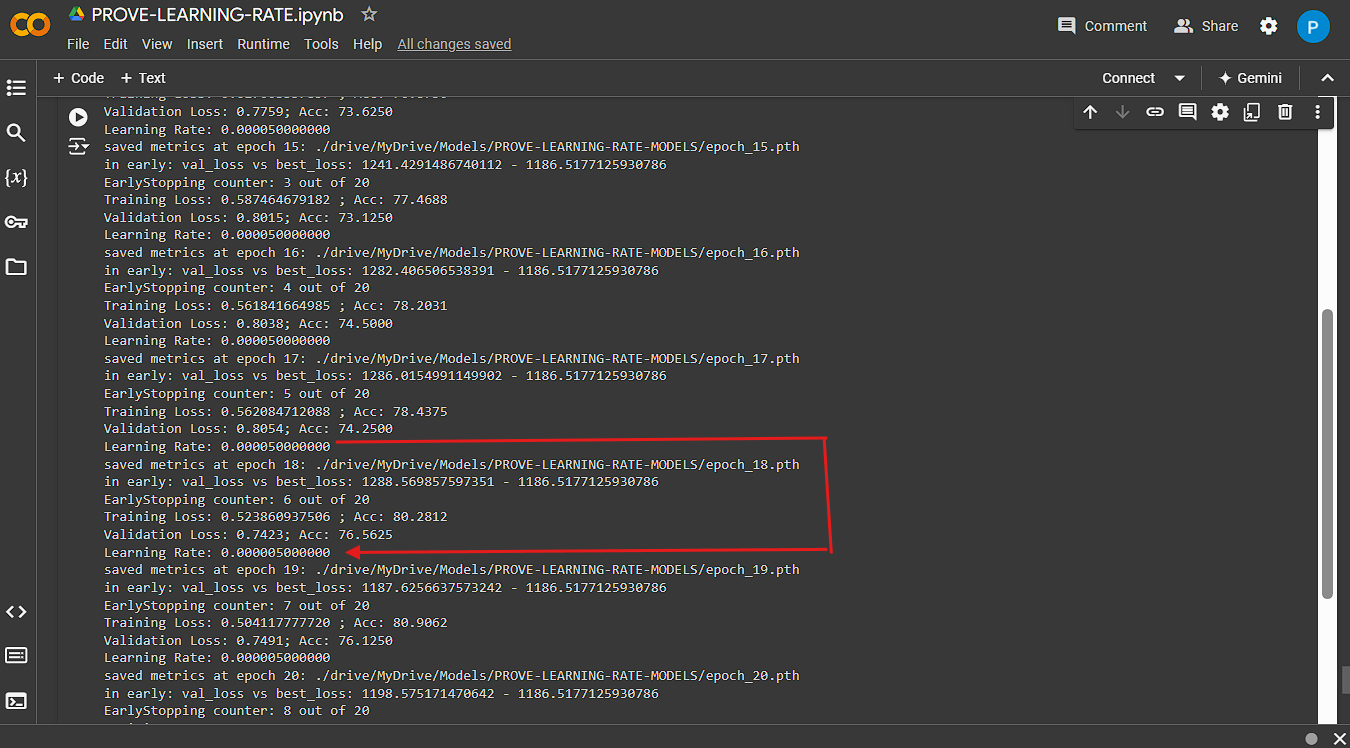

In [ ]:
num_epochs=70
current_epoch = 1
import warnings
warnings.filterwarnings("ignore", module="PIL")
early_stopping = EarlyStopping(patience=20, verbose=True)
train_model(model, train_loader, val_loader, criterion, optimizer,
            scheduler,current_epoch, num_epochs, checkpoint_savedir='./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS',early_stopping=early_stopping)

device: cuda
train size: 6400
val size: 1600
Training Loss: 1.464170047641 ; Acc: 34.9531
Validation Loss: 1.2979; Acc: 44.7500
Learning Rate: 0.000050000000
saved metrics at epoch 1: ./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/epoch_1.pth
in early: val_loss vs best_loss: 2076.6196670532227 - None
Best model updated with validation loss 1.2979 and saved at ./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/best_model.pth
Training Loss: 1.247860939503 ; Acc: 47.8750
Validation Loss: 1.0976; Acc: 53.6250
Learning Rate: 0.000050000000
saved metrics at epoch 2: ./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/epoch_2.pth
in early: val_loss vs best_loss: 1756.1003437042236 - 2076.6196670532227
Best model updated with validation loss 1.0976 and saved at ./drive/MyDrive/Models/PROVE-LEARNING-RATE-MODELS/best_model.pth
Training Loss: 1.121075458229 ; Acc: 53.5938
Validation Loss: 0.9882; Acc: 59.8125
Learning Rate: 0.000050000000
saved metrics at epoch 3: ./drive/MyDrive/Models/PROVE-LEA